# ARBOLES DE DECISION

Como las SVMs, los *árboles de decisión* son versátiles algoritmos de Machine Learning que pueden ejecutar tanto tareas de clasificación como de regresión, e incluso tareas multioutput. Son algoritmos muy poderosos, capaces de entrenar datasets complejos. Por ejemplo, en el capítulo 2 entrenamos un modelo `DecisionTreeRegressor` en el dataset de viviendas de California, ajustandolo perfectamente (en realidad, sobreajustándolo).

Los Arboles de Decisión son también los componentes fundamentales de los Bosques Aleatorios, los cuales se encuentran entre los algoritmos de Machine Learning más poderosos disponibles en la actualidad.

En este capítulo comenzaremos discutiendo cómo entrenar, visualizar y hacer predicciones con árboles de decisión. Luego iremos a través del algoritmo de entrenamiento CART usado por Scikit-Learn y veremos cómo regularizar árboles y a usarlos en tareas de regresión. Finalmente, discutiremos algunas de las limitaciones de los árboles de decisión.

# Entrenar y visualizar un Arbol de Decisión

Para comprender los árboles de decisión, contruyamos uno y echemos un vistazo a cómo realiza sus predicciones. El siguiente código entrena un `DecisionTreeClassifier` en el dataset de Iris:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.datasets import load_iris
from sklearn.tree import DecisionTreeClassifier

iris = load_iris()
X = iris.data[:, 2:] # largo y ancho de pétalo
y = iris.target

tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(X, y)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=2, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Podemos visualizar el árbol de decisión entrenado usando el método `export_graphviz()` para devolver un fichero de definición de grafo llamado *iris_tree.dot*:

In [3]:
#from graphviz import Source
from sklearn.tree import export_graphviz

export_graphviz(
        tree_clf,
        out_file="./images/ch06/iris_tree.dot",
        feature_names=iris.feature_names[2:],
        class_names=iris.target_names,
        rounded=True,
        filled=True
        )

Nuestro primer árbol de decisión se vería asi:

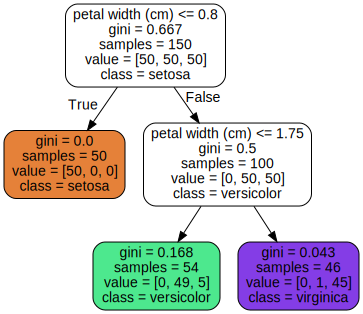

In [4]:
from graphviz import Source
Source.from_file("./images/Ch06/iris_tree.dot")

También podemos convertir este archivo *.dot* a formatos diversos como PDF o PNG usando el la herramienta de línea de comandos `dot` del paquete [graphwiz](http://www.graphviz.org/). Esta línea de comando convierte el archivo *.dot* en un archivo de imagen *.pgn*:

    $ dot -Tpng iris_tree.dot -o iris_tree.png

# Hacer predicciones

Veamos cómo el árbol representado en la figura anterior hace predicciones. Supongamos que encontramos una flor de iris y queremos clasificarla. Empezamos en el *nodo raíz* (profundidad 0, en la cima): este nodo pregunta si la longitud del pétalo de la flor es menor de 2,45 cm. Si es así, nos movemos abajo hacia el nodo hijo izquierdo (profundidad 1, izquierda). En este caso, es un *nodo hoja* (es decir, no tiene nodos hijos), por lo que no hacemos preguntas: simplemente miramos la clase pronosticada para ese nodo y el árbol de decisión predice que nuestra flor es una Iris-Setosa (`class=setosa`).

Ahora supongamos que encontramos otra flor, pero esta vez la longitud es mayor que 2,45 cm. Debemos movernos abajo hacia el nodo hijo derecho (profundidad 1, derecha), que no es un nodo hoja, por tanto, nos hace una pregunta: ¿es el ancho de pétalo menor que 1,75 cm? Si es que sí, entonces nuestra flor los más probable es que sea una Iris-Versicolor (profundidad 2, izquierda). Si es que no, es probablemente una Iris-Virginica (profundidad 2, derecha). Es realmente así de simple.

---

Una de las muchas cualidades de los Arboles de Decisión es que requieren muy pocos datos de preparación. En particular, no requieren escalado de características o centrado de todas ellas.

---

El atributo `samples` de un nodo cuenta a cuántas instancias de entrenamiento se aplica. Por ejemplo, 100 instancias de entrenamiento tienen una longitud de pétalo mayor que 2,45 cm (profundidad 1, derecha), de las cuales 54 tienen un ancho de pétalo menor que 1,75 cm (profundidad 2, izquiera). El atributo `value` de un nodo nos dice a cuántas instancias de entrenamiento de cada clase aplica ese nodo: por ejemplo, el nodo inferior derecho aplica a 0 Iris-Setosa, 1 Iris-Versicolor y a 45 Iris-Virginica. Finalmente, el atributo `gini`de un nodo mide su *impureza*: un nodo es "puro" (`gini=0`) si todas las instancias de entrenamiento que aplica pertenecen a la misma clase. Por ejemplo, dado que el nodo de profundidad 1 izquierdo aplica solo a instancias de entrenamiendo Iris-Setosa, es puro y su puntuación `gini` es 0. La siguiente ecuación muestra cómo el algoritmo de entrenamiento calcula la puntuación gini $G_i$ del nodo $i^{esimo}$. Por ejemplo, el nodo de profundidad 2 izquierdo tiene un `gini` igual a $1 - (\frac{0}{54})^2 - (\frac{49}{54})^2 - (\frac{5}{54})^2 \approx 0,168$. En breve discutiremos otra *medida de la impureza*.

***Impureza Gini***

$G_i = 1 - \displaystyle\sum_{k=1}^n p_{i,k}^2$

+ $p_{i,k}$ es el ratio de instancias de la clase *k* entre las instancias de entrenamiento en el i-ésimo nodo.

---

Scikit-Learn usa el algoritmo CART que produce solo *árboles binarios*: nodos no-hojas que siempre tienes dos hijos (es decir, preguntas que solo tienen respuestas de sí/no). Sin embargo, otros algoritmos como ID3 pueden producir árboles de decisión con nodos que tienen más de dos hijos.

---

La siguiente figura muestra los límites de decisión de este árbol de decisión. La línea vertical gruesa representa el límite de decisión del nodo raíz (profundidad 0): longitud de pétalo = 2,45 cm Dado que el área izquierda es pura (solo Iris-Setosa), no se puede dividir más. Sin embargo, el área derecha es impura, por tanto el nodo de profundidad 1 derecho la divide en ancho de pétalo = 1,75 cm. (representado por la línea de rayas). Dado que `max_depth` estaba establecido a 2, el árbol de decisión de detiene allí. Sin embargo, si establecemos `max_depth` a 3, entonces los dos nodos de profundidad 2 agregarían cada uno otro límite de decisión (representado por las líneas punteadas).

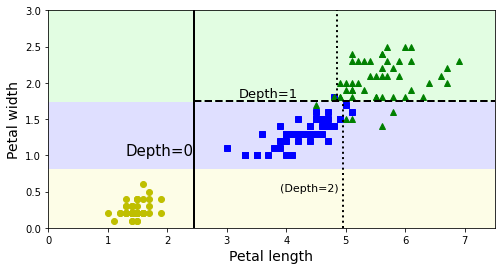

In [5]:
from matplotlib.colors import ListedColormap
import numpy as np

def plot_decision_boundary(clf, X, y, axes=[0, 7.5, 0, 3], iris=True, legend=False, plot_training=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if not iris:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    if plot_training:
        plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", label="Iris setosa")
        plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", label="Iris versicolor")
        plt.plot(X[:, 0][y==2], X[:, 1][y==2], "g^", label="Iris virginica")
        plt.axis(axes)
    if iris:
        plt.xlabel("Petal length", fontsize=14)
        plt.ylabel("Petal width", fontsize=14)
    else:
        plt.xlabel(r"$x_1$", fontsize=18)
        plt.ylabel(r"$x_2$", fontsize=18, rotation=0)
    if legend:
        plt.legend(loc="lower right", fontsize=14)

plt.figure(figsize=(8, 4))
plot_decision_boundary(tree_clf, X, y)
plt.plot([2.45, 2.45], [0, 3], "k-", linewidth=2)
plt.plot([2.45, 7.5], [1.75, 1.75], "k--", linewidth=2)
plt.plot([4.95, 4.95], [0, 1.75], "k:", linewidth=2)
plt.plot([4.85, 4.85], [1.75, 3], "k:", linewidth=2)
plt.text(1.30, 1.0, "Depth=0", fontsize=15)
plt.text(3.2, 1.80, "Depth=1", fontsize=13)
plt.text(3.90, 0.5, "(Depth=2)", fontsize=11);

---

***Interpretación del modelo: caja blanca versus caja negra***

Como podemos ver, los árboles de decisión son bastante intuitivos y sus decisiones son fáciles de interpretar. Tales modelos a menudo se denominan *modelos de caja blanca*. Por el contrario, como veremos, los bosques aleatorios o las redes neuronales se consideran generalmente *modelos de caja negra*. Hacen grandes predicciones y se pueden comprobar fácilmente los cálculos que realizan para hacer esas predicciones, sin embargo, generalmente es difícil explicar en términos simples por qué se hicieron las predicciones. Por ejemplo, si una red neuronal dice que una persona en particular aparece en una fotografía, es difícil saber qué es lo que realmente contribuye a esta predicción: ¿el modelo ha reconocido los ojos de la persona? ¿su boca? ¿su nariz? ¿sus zapatos? ¿o incluso el sofá en el que estaba sentada? A la inversa, los árboles de decisión proporcionan unas reglas de clasificación simples y fáciles que pueden ser aplicadas manualmente si fuera necesario (por ejemplo, para la clasificación de flores).

---

# Estimar la probabilidad de las clases

Un árbol de decisión también puede estimar la probabilidad de que una instancia pertenezca a una clase *k* particular: primero recorre el árbol para encontrar el nodo hoja para esta instancia y después devuelve el ratio de instancias de entrenamiento de la clase *k* en ese nodo. Por ejemplo, supongamos que hemos encontrado una flor cuyos pétalos son de 5 cm de largo y de 1,5 cm de ancho. El nodo hoja correspondiente es el nodo de profundidad 2 izquierdo, por tanto, el árbol de decisión debe devolver las siguientes probabilidades: 0% para Iris-Setosa (0/54), 90,7% para Iris-Versicolor (49/54) y 9,3% para Iris-Virginica (5/54). Y por supuesto si preguntamos la predicción de la clase, debería devolver Iris-Versicolor (clase 1), dado que es la probabilidad más alta. Vamos a comprobarlo:

In [6]:
tree_clf.predict_proba([[5, 1.5]])

array([[0.        , 0.90740741, 0.09259259]])

In [7]:
tree_clf.predict([[5, 1.5]])

array([1])

¡Perfecto! Observemos que las probabilidades estimadas serían idénticas en cualquier otro lugar en el rectángulo inferior derecho de la figura anterior, por ejemplo, si los pétalos fueran de 6 cm de largo y 1,5 cm de ancho (aunque parece obvio que probablemente sería una Iris-Virginica en este caso).

# El algoritmo de entrenamiento CART

Scikit-Learn usa el algoritmo de *Arboles de Regresión y Clasificación (CART - Clasification And Regression Tree)* para entrenar árboles de decisión (también llamado árboles "en crecimiento"). La idea es bastante simple realmente: en primer lugar, el algoritmo divide el conjunto de entrenamiento en dos subconjuntos usando una única característica *k* y un umbral $t_k$ (por ejemplo, "longitud de pétalo <= 2,45 cm") ¿Cómo elige *k* y $t_k$? Busca el par (*k*, $t_k$) que produce el subconjunto más puro (ponderados por su tamaño). La función de coste que el algoritmo intenta minimizar es dada por la siguiente ecuación:

***Función de coste CART para clasificación***

$J(k, t_k) = \frac{m_{izq}}{m}G_{izq} + \frac{m_{der}}{m}G_{der}$

donde, $\begin{cases} 
            G_{\text {izq/der}} \text { mide la impureza del subconjunto izquierdo/derecho}\\ 
            m_{\text {izq/der}} \text { es el número de instancias del subconjunto izquierdo/derecho} 
       \end{cases}$

Una vez que se ha dividido el conjunto de entrenamiento en dos, divide los subconjuntos usando la misma lógica, luego los sub-subconjuntos y así sucesivamente, recursivamente. La recursión se detiene una vez alcanzada la máxima profundidad (definida por el hiperparámetro `max_depth`) o si no se puede encontrar una división que reduzca la impureza. Algunos otros hiperparámetros (que se describirán en breve) controlan otras condiciones de detención adicionales (`min_samples_split`, `min_samples_leaf`, `min_weight_fraction` y `max_leaf_nodes`).

---

Como podemos ver, el algoritmo CART es un *algoritmo ávido*: busca con avidez una división óptima en el nivel superior, luego repite el proceso por cada nivel. No comprueba si la división conduce o no a la impureza más baja posible varios niveles hacia abajo. Un algoritmo ávido a menudo produce una solución razonablemente buena, pero no garantiza que sea la solución óptima.

Desafortunadamente, se sabe que encontrar el árbol óptimo es un problema *NP-Completo*: requiere un tiempo $O^m$, lo que hace que el problema sea intratable incluso para conjuntos de entrenamiento bastante pequeños. Esto es por lo que debemos quedarnos con una solución "razonablemente buena".

Problema *NP-Completo*: P es el conjunto de problemas que se pueden resolver en tiempo polinómico. NP es el conjunto de problemas cuyas soluciones pueden verificarse en tiempo polinómico. Un problema NP-Duro es un problema al que cualquier problema NP puede reducirse en tiempo polinómico. Un problema de NP-Completo es NP y NP-Duro. Una importante pregunta matemática abierta es si P = NP o no. Si P ≠ NP (lo que parece probable), entonces nunca se encontrará un algoritmo polinomial para ningún problema NP-Completo (excepto quizás en una computadora cuántica).

---

# Complejidad computacional

Hacer predicciones requiere recorrer el árbol de decisión desde la raíz hasta una hoja. Los árboles de decisión generalmente están aproximadamente balanceados, por tanto, atravesar el árbol de decisión requiere pasar por aproximadamente nodos *O(log$_2$(m))* ($log_2$ es el logaritmo binario: es igual a $log_2(m) = log(m)\, /\, log(2)$). Dado que cada nodo solo requiere comprobar el valor de una característica, la complejidad de predicción global es solo *O(log$_2$(m))*, independiente del número de características. Por lo tanto, las predicciones son muy rápidas, incluso cuando se trata de grandes conjuntos de entrenamiento.

Sin embargo, el algoritmo de entrenamiento compara todas las características (o menos si se establece `max_features`) en todas las muestras de cada nodo. Esto resulta en una complejidad de entrenamiento de *O(n x m log(m))*. Para conjuntos de entrenamiento pequeños (menos de unas miles de instancias), Scikit-Learn puede acelerar el entrenamiento preordenando los datos (estableciendo `presort=True`), pero esto ralentiza considerablemente el entrenamiento para grandes conjuntos de entrenamiento.

# ¿Impureza Gini o Entropía?

De manera predeterminada, se usa Gini como medida de impureza, pero en su lugar podemos seleccionar la *entropía* como medida de impureza estableciendo el hiperparámetro `criterion = "entropy"`. El concepto de entropía se originó en la termodinámica como una medida del desorden molecular: la entropía es cercana a cero cuando las moléculas están inmóviles y bien ordenadas. Más tarde se extendió a una gran variedad de dominios, incluyen la *teoría de la información* de Shannon, donde mide el promedio de información que contiene un mensaje (una reducción de la entropía se denomina a menudo *ganancia de información*): la entropía es cero cuando todos los mensajes son idénticos. En Machine Learning, es frecuente usarla como una medida de la impureza: la entropía de un conjunto es cero cuando contiene instancias de solo una clase. La siguiente ecuación muestra la definición de entropía del nodo iésimo. Por ejemplo, el nodo de profundidad 2 izquiero en la representación gráfica del árbol al principio del capítulo es igual a $-\frac{45}{54} log_2 \left(\frac{49}{54}\right) - \frac{5}{54} log_2 \left(\frac{5}{54}\right) \approx 0,445$

###Entropía###

![entropy](./images/Ch06/entropy.png)

Entonces, ¿debemos usar la impureza Gini o entropía? La verdad es que la mayor parte de las veces no hay una gran diferencia: producen árboles similares. La impureza Gini es ligeramente más rápida de calcular, así que es buena por defecto. Sin embargo, cuando difieren, la impureza Gini tiende a asilar la clase más frecuente en su propia rama del árbol, mientras que la entropía tiende a producir [árboles ligeramente más balanceados](https://homl.info/19).

# Hiperparámetros de regularización

Los árboles de decisión hacen muy pocas suposiciones sobre los datos de entrenamiento (al contrario que lo modelos lineales, que obviamente asumen que los datos son lineales, por ejemplo). Si no se restringe, la estructura del árbol se adaptará por si misma a los datos de entrenamiento, ajustándose muy de cerca y, muy probablemente, sobreajustándose. Un modelo tal se denomina *modelo no paramétrico*, no porque no tenga ningún parámetro (a menudo tiene muchos) sino porque el número de parámetros no se determina antes del entrenamiento, por tanto la estructura del modelo es libre de adherirse a los datos. Por el contrario, un *modelo paramétrico*, como un modelo lineal, tiene un numero predeterminado de parámetros, por lo que su grado de libertad es limitado, reduciendo el riesgo de sobreajuste (pero incrementando el riesgo de subajuste).

Para evitar sobreajustar los datos de entrenamiento, necesitamos restringir la libertad de los árboles de decisión durante el entrenamiento. Como ya sabemos, esto se denomina regularización. Los hiperparámetros de regularización dependen del algoritmo usado, pero generalmente al menos podemos restringir la profundidad máxima del árbol de decisión. En Scikit-Learn esto se controla con el hiperparámetro `max_depth` (el valor por defecto es `None`, lo que significa sin límite). Reducir `max_depth` regularizará el modelo y, por tanto, reducirá el riesgo de sobreajuste.

La clase `DecisionTreeClassifier` tiene otros cuantos parámetro que restringen de forma similar la forma del árbol de decisión: `min_samples_split`(número mínimo de muestras que un nodo debe tener antes de poder ser dividido), `min_samples_leaf` (número mínimo de muestras que un nodo hoja debe tener), `min_weight_fraction_leaf`(lo mismo que `min_samples_leaf` pero expresado como una fracción del número total de instancias ponderadas), `max_leaf_nodes` (número máximo de nodos hoja) y `max_features`(número máximo de características que son evaluadas para dividir cada nodo). Incrementar los hiperparámetros `min_*` o reducir los hiperparámetros `max_*` regularizará el modelo.

---

Otros algoritmos trabajan entrenando primero el árbol de decisión sin restricciones, luego *podan* (borran) nodos innecesarios. Un nodo cuyos hijos son todos nodos hoja se considera innecesario si la mejora de pureza que proporciona no es *estadísticamente significativa*. Las pruebas estadísticas estándar, tales como $\chi^2$, se usan para estimar la probabilidad de que la mejora sea puramente fruto del azar (la cual se denomina *hipótesis nula*). Si esta probabilidad, llamada *p-valor*, es mayor que un umbral dado (típicamente el 5%, controlado por un hiperparámetro), entonces el nodo se considera innecesario y su hijo es borrado. La poda continúa hasta que todos los nodos innecesarios han sido podados.

---

La siguiente gráfica muestra dos árboles de decisión entrenados en el dataset de luneas (que vimos en el capítulo anterior). A la izquierda, el árbol de decisión es estrenado con los hiperparámetros por defecto (es decir, sin restricciones) y, a la derecha, el árbol de decisión es entrenado con `min_samples_leaf=4`. Es bastante obvio que el modelo de la izquierda está sobreajustado y el modelo de la derecha probablemente generalizará mejor.

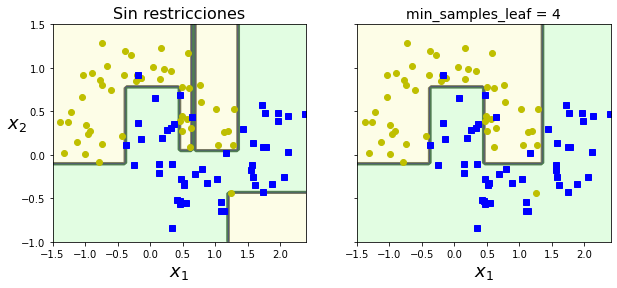

In [11]:
from sklearn.datasets import make_moons
Xm, ym = make_moons(n_samples=100, noise=0.25, random_state=53)

deep_tree_clf1 = DecisionTreeClassifier(random_state=42)
deep_tree_clf2 = DecisionTreeClassifier(min_samples_leaf=4, random_state=42)
deep_tree_clf1.fit(Xm, ym)
deep_tree_clf2.fit(Xm, ym)

fig, axes = plt.subplots(ncols=2, figsize=(10, 4), sharey=True)
plt.sca(axes[0])
plot_decision_boundary(deep_tree_clf1, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("Sin restricciones", fontsize=16)
plt.sca(axes[1])
plot_decision_boundary(deep_tree_clf2, Xm, ym, axes=[-1.5, 2.4, -1, 1.5], iris=False)
plt.title("min_samples_leaf = {}".format(deep_tree_clf2.min_samples_leaf), fontsize=14)
plt.ylabel("");